## Business Understanding
Our task for this lab is to create our own logistic regression model which is able to classify how many Uber pickups there will be (low, medium, or high) based off of different information in our dataset. The dataset is a collection of information about Uber pickups like time and location, joined with other data such as the weather for that time and location, what borough it is in, and whether or not it was a NYC public holiday. We split our predictions up by borough because certain boroughs like Manhattan generally always have a higher volume of pickups than boroughs like the Bronx, so aggregate predictions over all of NYC would not have been very insightful. Instead, we make predictions specific to each borough, with the exception of EWR and Staten Island, which we threw out because they did not contain enough data to make accurate predictions. We denote a "high" amount of pickups as greater than half a standard deviation above the mean for that borough. A "low" amount is less than half a standard deviation below the mean for that borough. A "medium" amount is inbetween. 

Our prediction task is valuable because it gives Uber insight into the time periods where they can be most profitable, and time periods where they can save money. For example, on New Years Eve there is most likely an extreme surge in the number of rides requested. If there are not enough drivers to satisfy all of these rides, people will go to Lyft or even just hail a yellow cab. However, if they prepare for this surge by incentivising drivers with an extra percentage of the ride money, there will be more drivers to satisfy the extra rides requests. Our model's insights would help pull in more profits and increases market share compared to treating every day and location as equally profitable. In production, this model would provide the best results if it were deployed so that it would run constantly and react to changing weather conditions, social movements, etc.

In [3]:
import numpy as np

## Data Prep

In [4]:
import pandas as pd
data = pd.read_csv("./data/uber_nyc_enriched.csv")

In [5]:
data.describe()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
count,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000
mean,490.215903,5.984924,8.818125,47.669042,30.823065,1017.817938,0.003830,0.026129,0.090464,2.529169
std,995.649536,3.699007,2.442897,19.814969,21.283444,7.768796,0.018933,0.093125,0.219402,4.520325
min,0.000000,0.000000,0.000000,2.000000,-16.000000,991.400000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,9.100000,32.000000,14.000000,1012.500000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,6.000000,10.000000,46.000000,30.000000,1018.200000,0.000000,0.000000,0.000000,0.000000
75%,449.000000,8.000000,10.000000,64.500000,50.000000,1022.900000,0.000000,0.000000,0.050000,2.958333
max,7883.000000,21.000000,10.000000,89.000000,73.000000,1043.400000,0.280000,1.240000,2.100000,19.000000


<p> checking for nan or null values in the dataset </p>

In [6]:
data.isnull().values.any()

True

<p> We found only Borough has nan values so we remove the nan rows </p>

In [7]:
data.isnull().any()

pickup_dt    False
borough       True
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

In [8]:
data = data.dropna()

In [9]:
data.isnull().any()

pickup_dt    False
borough      False
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

<p> We found that most of our data didnt have much correlation except temperate and the dew point temperature. We decided to get rid of this variable becasue it seemed very similar to temperature and did not think it would impact the machine learning. </p>

In [10]:
data.corr()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
pickups,1.000000,0.009741,-0.008429,0.063692,0.040082,-0.015708,0.005007,-0.002821,-0.022935,-0.009676
spd,0.009741,1.000000,0.086177,-0.296126,-0.321606,-0.092761,-0.000357,0.016668,-0.010412,0.097041
vsb,-0.008429,0.086177,1.000000,0.025214,-0.231294,0.167039,-0.488407,-0.118346,0.000895,-0.047834
temp,0.063692,-0.296126,0.025214,1.000000,0.896544,-0.224537,-0.013343,-0.037295,-0.014408,-0.545558
dewp,0.040082,-0.321606,-0.231294,0.896544,1.000000,-0.311156,0.115399,0.013293,0.001519,-0.489372
slp,-0.015708,-0.092761,0.167039,-0.224537,-0.311156,1.000000,-0.089752,-0.104940,-0.134689,0.121508
pcp01,0.005007,-0.000357,-0.488407,-0.013343,0.115399,-0.089752,1.000000,0.128064,0.000997,0.000310
pcp06,-0.002821,0.016668,-0.118346,-0.037295,0.013293,-0.104940,0.128064,1.000000,0.251166,0.039943
pcp24,-0.022935,-0.010412,0.000895,-0.014408,0.001519,-0.134689,0.000997,0.251166,1.000000,0.069664
sd,-0.009676,0.097041,-0.047834,-0.545558,-0.489372,0.121508,0.000310,0.039943,0.069664,1.000000


In [11]:
del data['dewp']

<p> We made the holiday column count 1 for yes and 0 for no. </p>

In [12]:
data['hday'] = data['hday'].apply(lambda x: 0 if x=='N' else 1)

<p> We one hot encoded our boroughs becuase they were string values </p>

In [13]:
oneHotCols = pd.get_dummies(data['borough'])
data = data.join(oneHotCols)

In [14]:
del data['borough']

### 1 hot encoding the time of day

<p> We based our hour groups by sunrise and sunset. Night is the time when the sun is down, which on average is from 8pm to 6am. Morning is from 6am till noon. Afternoon is from noon till 5pm. Evening is from 5pm till 8pm, which is around when the sunsets. 

In [15]:
dateTest = data['pickup_dt'][0]
print(int(dateTest[11:13]))
data['is_morning'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 6 and int(x[11:13]) < 12) else 0)
data['is_afternoon'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 12 and int(x[11:13]) < 17) else 0)
data['is_evening'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 17 and int(x[11:13]) < 21) else 0)
data['is_night']  = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 21 or int(x[11:13]) < 6) else 0)

1


### 1 hot encoding the weekday

The weekday from the pickup_dt feature has been 1 hot encoded into monday-sunday. We believe having each day as a feature will help classify & predict the number of ubers necessary at a future date

In [16]:
import datetime
data['is_monday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 0 else 0)
data['is_tuesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 1 else 0)
data['is_wednesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 2 else 0)
data['is_thursday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 3 else 0)
data['is_friday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 4 else 0)
data['is_saturday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 5 else 0)
data['is_sunday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 6 else 0)

In [17]:
del data['pickup_dt']

<p> We found that the borough EWR averages about 2.4 pickups every 96 hours so we are getting rid of the EWR borough from our dataset. We found that the borough Staten Island averages 1.6 pickups and hour and had a max 13 pickups in an hour over 6 months so we got rid of it from our dataset. </p>

In [18]:
d1 = data.where(data['EWR']==1)[['pickups','EWR']]
print(d1.describe())
d1 = d1.dropna()
data = data[data.EWR == 0]
del data['EWR']
d1 = data.where(data['Staten Island']==1)[['pickups','Staten Island']]
print(d1.describe())
d1 = d1.dropna()
data = data[data['Staten Island'] == 0]
del data['Staten Island']

           pickups     EWR
count  4343.000000  4343.0
mean      0.024177     1.0
std       0.160937     0.0
min       0.000000     1.0
25%       0.000000     1.0
50%       0.000000     1.0
75%       0.000000     1.0
max       2.000000     1.0
           pickups  Staten Island
count  4343.000000         4343.0
mean      1.601888            1.0
std       1.640451            0.0
min       0.000000            1.0
25%       0.000000            1.0
50%       1.000000            1.0
75%       2.000000            1.0
max      13.000000            1.0


## Making our Categories

<p> We have three cateogries of pickup traffic low, medium, high. We found these by finding the mean and standard deviation of each borough. Low is half a standard deviation below the mean and high is half a stadard deviation above the mean. Anything else is counted as a medium amount of pickups. This means that the category of low, medium, and high pickup amount depends on the borough. If we did base our categories by borough then Manhattan would always be in the high pickup amount category and Queens would always be in the low pickup amount category.  </p> 

In [19]:
Man = data[data.Manhattan == 1]
Bronx = data[data.Bronx == 1]
Queens = data[data.Queens == 1]
Brooklyn = data[data.Brooklyn == 1]

print(Man['pickups'].describe())
print(Bronx['pickups'].describe())
print(Queens['pickups'].describe())
print(Brooklyn['pickups'].describe())

count    4343.000000
mean     2387.253281
std      1434.724668
min         0.000000
25%      1223.500000
50%      2269.000000
75%      3293.500000
max      7883.000000
Name: pickups, dtype: float64
count    4343.000000
mean       50.667050
std        31.029223
min         0.000000
25%        29.000000
50%        46.000000
75%        66.000000
max       262.000000
Name: pickups, dtype: float64
count    4343.000000
mean      309.354824
std       154.368300
min         0.000000
25%       196.000000
50%       308.000000
75%       410.000000
max       831.000000
Name: pickups, dtype: float64
count    4343.000000
mean      534.431269
std       294.810182
min         0.000000
25%       331.500000
50%       493.000000
75%       675.000000
max      2009.000000
Name: pickups, dtype: float64


<p> Using the mean and stadard deviation of each borough to place each row of data into a category. We can see that our categories are almost completely balanced within each borough.  </p> 

In [20]:
mstd = Man['pickups'].std()
mmean = Man['pickups'].mean()
bstd = Bronx['pickups'].std()
bmean = Bronx['pickups'].mean()
qstd = Queens['pickups'].std()
qmean = Queens['pickups'].mean()
brstd = Brooklyn['pickups'].std()
brmean = Brooklyn['pickups'].mean()
data['pickupPrediction'] = 0
for index, row in data.iterrows():
    if(row['Manhattan'] == 1):
        if(row['pickups']  < (mmean - mstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (mmean + mstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['Bronx'] == 1):
        if(row['pickups']  < (bmean - bstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (bmean + bstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['Queens'] == 1):
        if(row['pickups']  < (qmean - qstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (qmean + qstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
    if(row['Brooklyn'] == 1):
        if(row['pickups']  < (brmean - brstd/2)):
            data.set_value(index,'pickupPrediction',0)
        elif(row['pickups'] > (brmean + brstd/2)):
            data.set_value(index,'pickupPrediction',2)
        else:
            data.set_value(index,'pickupPrediction',1)
print(data['pickupPrediction'].describe())
print(data['pickupPrediction'].value_counts())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
//an

count    17372.000000
mean         0.935816
std          0.771724
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: pickupPrediction, dtype: float64
1    6955
0    5766
2    4651
Name: pickupPrediction, dtype: int64


In [21]:
data.reset_index(inplace=True, drop=True)
for index, row in data.iterrows():
    if(index < 12):
        continue
    data.set_value(index,'1hrAgo',data['pickupPrediction'][index-4])
    data.set_value(index,'2hrsAgo',data['pickupPrediction'][index-8])
    data.set_value(index,'3hrsAgo',data['pickupPrediction'][index-12])
data = data.iloc[12:]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [22]:
x = data
y = data['pickupPrediction']

In [23]:
del x['pickupPrediction']
del x['pickups']

## Normalizing data

In [24]:
from sklearn import preprocessing

x = x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)

## Metric Used
<p> We believe using an f1-socre would be the best evaluation metric in our case. We need to take into account the false positive and false negative rate because our logisitc regression on the algorithm would always guesses one class which results in a precision of 100% for that class. We care about any form of misclassification of our pickup class prediction. We will give false negatives a higher cost because this means we have too few ubers in an area based off our preditcion. If we have a false positive then it means we have too many ubers in an area, which is bad, but not as bad as having too few. </p>

In [25]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report

# pipe_lr = Pipeline([('scl', StandardScaler()),
#                     ('clf', LogisticRegression())])

# pipe_lr.fit(xTrain, yTrain)
# y_pred = pipe_lr.predict(xTest)
# print(classification_report(yTest, y_pred))

## Splitting Data
We choose to use continuous test and training sets as our uber pickups were given hourly over a 6 month span. Our algorithm in the real world would be getting the data in hourly and then have to predict based off this new hourly data. We split our data into 10 folds splitting our data by the time that it occured. 

In [26]:
x.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

pd.set_option('display.max_columns', 500)
x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
count,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000,17360.000000
mean,0.285771,0.881921,0.523001,0.507870,0.013655,0.021042,0.043380,0.133592,0.037788,0.250000,0.250000,0.250000,0.250000,0.250230,0.208525,0.166820,0.374424,0.143779,0.143779,0.138249,0.142857,0.143779,0.143779,0.143779,0.467569,0.467569,0.467598
std,0.176538,0.244367,0.227285,0.149713,0.067286,0.074957,0.105000,0.237982,0.190689,0.433025,0.433025,0.433025,0.433025,0.433158,0.406266,0.372826,0.483988,0.350875,0.350875,0.345171,0.349937,0.350875,0.350875,0.350875,0.385763,0.385763,0.385784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.910000,0.342146,0.403846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.285714,1.000000,0.500958,0.515385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
75%,0.380952,1.000000,0.712644,0.605769,0.000000,0.000000,0.024603,0.167763,0.000000,0.250000,0.250000,0.250000,0.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<p> The data was already in order by hour. Each four rows represented one boroughs uber and weather data. We split our data into 10 folds for training. </p>

In [27]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(x.values,y.values):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 2892 2893 2894] TEST: [2895 2896 2897 ... 5785 5786 5787]
TRAIN: [   0    1    2 ... 5785 5786 5787] TEST: [5788 5789 5790 ... 8678 8679 8680]
TRAIN: [   0    1    2 ... 8678 8679 8680] TEST: [ 8681  8682  8683 ... 11571 11572 11573]
TRAIN: [    0     1     2 ... 11571 11572 11573] TEST: [11574 11575 11576 ... 14464 14465 14466]
TRAIN: [    0     1     2 ... 14464 14465 14466] TEST: [14467 14468 14469 ... 17357 17358 17359]


In [28]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/10, random_state = 0)

## Modeling

In [29]:
# how do we compare now to sklearn?
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression as LogisticRegressionSci
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
#From Sklearn documentation 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [30]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                act_func='sigmoid',cost_func='quadratic',layers=2):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.act_func = act_func
        self.cost_func = cost_func
        self.layers = layers
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        W = []
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        W.append(W1)
        for i in range(0,self.layers-2):
            W1_num_elems = (self.n_hidden + 1)*self.n_hidden
            W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
            W1 = W1.reshape(self.n_hidden, self.n_hidden + 1) # reshape to be W
            W.append(W1)
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        W.append(W2)
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        total = 0 
        for i in W:
            total += np.mean(i[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(total)
    
    def _cost(self,A2,Y_enc,W):
        '''Get the objective function value'''
        if(self.cost_func == 'quadratic'):
            cost = np.mean((Y_enc-A2)**2)
        else:
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A2)+(1-Y_enc)*np.log(1-A2))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term

In [325]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _initialize_weights(self):
        if(self.act_func=='relu' or self.act_func=='silu'):
            W = []
            """Initialize weights with small random numbers."""
            
            init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
            W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
            W1[:,:1] = 0

            W.append(W1)
            for i in range(0,self.layers-2):
                W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1))
                W1[:,:1] = 0
                W.append(W1)
            init_bound = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
            W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
            W2[:,:1] = 0

            W.append(W2)
        else:
            W = []
            """Initialize weights with small random numbers."""
            W1_num_elems = (self.n_features_ + 1)*self.n_hidden
            W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
            W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
            W.append(W1)
            for i in range(0,self.layers-2):
                W1_num_elems = (self.n_hidden + 1)*self.n_hidden
                W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
                W1 = W1.reshape(self.n_hidden, self.n_hidden + 1) # reshape to be W
                W.append(W1)
            W2_num_elems = (self.n_hidden + 1)*self.n_output_
            W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
            W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
            W.append(W2)
        return W
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    def _silu(self,Z):
        return Z * self._sigmoid(Z)
    
    def _feedforward(self, X, W1,i,lastLayer):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        if(self.act_func == 'sigmoid'):
            A2 = self._sigmoid(Z1)
        elif(self.act_func == 'relu'):
            if(i ==lastLayer):
                A2 = self._sigmoid(Z1)
                
            else:
                A2 = self._relu(Z1)
        elif(self.act_func=='silu'):
            if(i ==lastLayer):
                A2 = self._sigmoid(Z1)
            else:
                A2 = self._silu(Z1)
        else:
            A2 = Z1

        return A1, Z1, A2
    
    def _get_gradient(self, A, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        ones = np.ones(self.n_hidden + 1)
        grads = []

        for i2 in range(len(self.W)-1,-1,-1):
            grad1 = np.zeros(W[i2].shape)
            if(i2 == len(self.W)-1):
                if(self.cost_func == 'quadratic'):
                    dJ_dz2 = -2*(Y_enc - A[i2+1])*A[i2+1]*(1-A[i2+1])
                else:
                    dJ_dz2 = A[i2+1]-Y_enc

                grad1 += dJ_dz2  @ A[i2].T
            else:
                if(self.act_func == 'sigmoid'):
                    dJ_dz1 =A[i2+1]*(1-A[i2+1]) *( W[i2+1].T @ dJ_dz2 )
                elif(self.act_func == 'relu'):
                    Z_with_bias = self._add_bias_unit(Z[i2],how='row')
                    dJ_dz1 = ( W[i2+1].T @ dJ_dz2 ) 
                    dJ_dz1[Z_with_bias<=0] = 0
                elif(self.act_func=='silu'):
                    Z_with_bias = self._add_bias_unit(Z[i2],how='row')
                    dJ_dz1 = (self._sigmoid(Z_with_bias) * 
                                          (1 + Z_with_bias*(1-self._sigmoid(Z_with_bias))))
                    
                else:
                    dJ_dz1 = W[i2+1].T@ dJ_dz2 
                grad1 += dJ_dz1[1:,:] @ A[i2].T
            grads.insert(0,grad1)
            if(i2 < len(self.W)-1):
                dJ_dz2 = dJ_dz1[1:]
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
#         # regularize weights that are not bias terms
        for i in range(0,len(W)):
            grads[i][:, 1:] += (W[i][:, 1:] * self.l2_C)
        return grads
    
    def predict(self, X):
        """Predict class labels"""
        for i in range(0,len(self.W)):
            if(i>0):
                X = A2.T
            A1, Z1, A2 = self._feedforward(X,self.W[i],i,len(self.W)-1)
        y_pred = np.argmax(A2, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.grad_ws_ = []
        for i in range(0,self.layers):
            self.grad_ws_.append([])
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            # feedforward all instances
            A = []
            Z = []
            X_data = X.copy()
            for i2 in range(0,len(self.W)):
                W1 = self.W[i2]
                if(i2>0):
                    X_data = A2.T
                A1, Z1, A2 = self._feedforward(X_data,W1,i2,len(self.W)-1)
                if(i2 == 0):
                    A.append(A1)
                if(i2 != len(self.W)-1):
                    A3 = self._add_bias_unit(A2, how='row')
                    A.append(A3)
                else:
                    A.append(A2)
                Z.append(Z1)
            cost = self._cost(A[len(A)-1],Y_enc,self.W)
            self.cost_.append(cost)
            # compute gradient via backpropagation
            ## return an array of gradients to update weight array
            ## iterate inside of get gradient function instead
            grads = self._get_gradient(A=A, Z=Z,Y_enc=Y_enc, W=self.W)
            for i in range(0,len(grads)):
                self.grad_ws_[i].append(np.mean(np.absolute(grads[i])))
            for i in range(0,len(grads)):
                self.W[i] -= self.eta * grads[i]
        return self

In [326]:
params = dict(n_hidden=50, 
                C=0.1,
                epochs=100,
                eta=0.001,
                random_state=1,
                act_func='silu',
                cost_func='quadratic',
                layers=3)

Epoch: 10/100

fold 1


Epoch: 100/100

Confusion matrix, without normalization
[[1003    0    0]
 [1278    0    0]
 [ 612    0    0]]
Test acc: [0.51488706 0.         0.        ]
fold 2


Epoch: 100/100

Confusion matrix, without normalization
[[   0 1043    0]
 [   0 1310    0]
 [   0  540    0]]
Test acc: [0.         0.62336426 0.        ]
fold 3


Epoch: 100/100

Confusion matrix, without normalization
[[   0    0  864]
 [   0    0 1363]
 [   0    0  666]]
Test acc: [0.         0.         0.37426243]
fold 4


Epoch: 100/100

Confusion matrix, without normalization
[[   0  649    0]
 [   0 1052    0]
 [   0 1192    0]]
Test acc: [0.         0.53333333 0.        ]
fold 5


Epoch: 100/100

Confusion matrix, without normalization
[[ 572    0    0]
 [ 968    0    0]
 [1353    0    0]]
Test acc: [0.33015873 0.         0.        ]
CPU times: user 1min 26s, sys: 5.87 s, total: 1min 32s
Wall time: 23.8 s


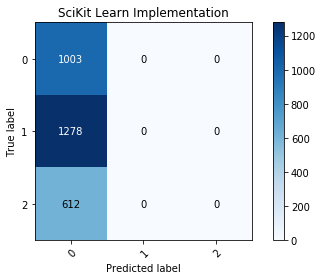

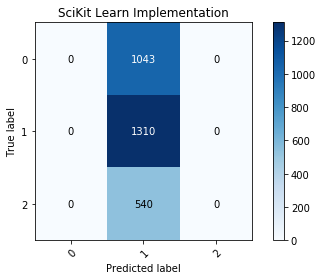

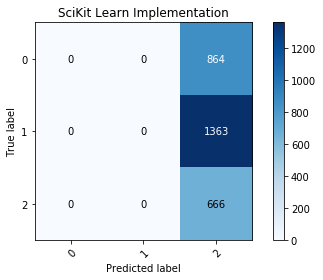

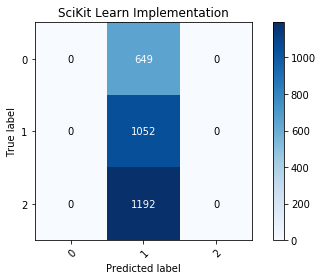

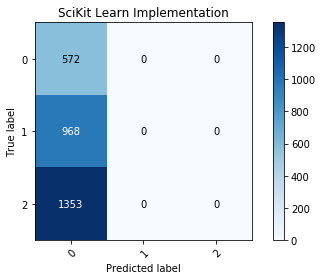

In [327]:
%%time 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
nn = TwoLayerPerceptron(**params)
i = 1
for train_index, test_index in tscv.split(x.values,y.values):
    print('fold', i)
    X_train, X_test = x.iloc[train_index].values, x.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
    nn.fit(X_train, y_train, print_progress=10)
    yhat = nn.predict(X_test)
    class_names = ['low','medium','high']
    plot_confusion_matrix(y_test, yhat, classes=class_names,
                      title='SciKit Learn Implementation')
    print('Test acc:',f1_score(y_test,yhat,average=None))
    i +=1

## Visualizing Gradients

Epoch: 200/200

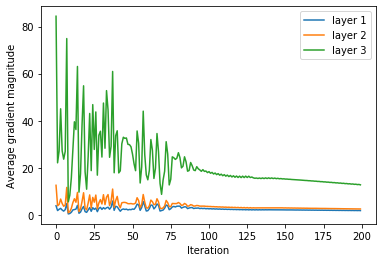

In [330]:
paramsVis = dict(n_hidden=50,
                C=0.1,
                epochs=200,
                eta=0.001,
                random_state=1,
                act_func='sigmoid',
                cost_func='quadratic',
                layers=3)
nn2 = TwoLayerPerceptron(**paramsVis)
nn2.fit(x[:2000],y[:2000], print_progress=10)
ax = plt.subplot(1,1,1)
for i in range(0,len(nn2.grad_ws_)): 
    plt.plot(nn2.grad_ws_[i][0:], label=('layer '+str(i+1)))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply
Epoch: 200/200

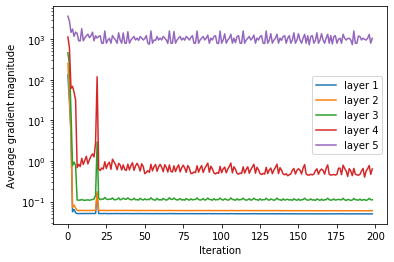

In [338]:
paramsVis = dict(n_hidden=50, 
                C=0.1,
                epochs=200,
                eta=0.001,
                random_state=1,
                act_func='sigmoid',
                cost_func='cross',
                layers=5)
nn2 = TwoLayerPerceptron(**paramsVis)
nn2.fit(x,y, print_progress=10)
ax = plt.subplot(1,1,1)
for i in range(0,len(nn2.grad_ws_)): 
    plt.plot(nn2.grad_ws_[i][1:], label=('layer '+str(i+1)))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.yscale('log')
plt.show()

# Hyper Parameter Tuning

In [ ]:
# hyperparams - phi function, objective function, and number of layers
f1_scores = {}
for phi in ['sigmoid', 'linear']:
    for obj_func in ['cross-entropy', 'quadratic']:
        for num_layers in range(2,5):
            params = dict(n_hidden=50, 
                C=0.1,
                epochs=100,
                eta=0.001,
                random_state=1,
                act_func=phi,
                cost_func=obj_func,
                layers=num_layers)
            nn = TwoLayerPerceptron(**params)
            i = 1
            for train_index, test_index in tscv.split(x.values,y.values):
                print('fold', i)
                X_train, X_test = x.iloc[train_index].values, x.iloc[test_index].values
                y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values
                nn.fit(X_train, y_train, print_progress=10)
                yhat = nn.predict(X_test)
                class_names = ['low','medium','high']
                #plot_confusion_matrix(y_test, yhat, classes=class_names,
                                  #title='SciKit Learn Implementation')
                print('Test acc:',f1_score(y_test,yhat,average=None))
                f1_scores[phi+"_"+obj_func+str(num_layers)+'_'+i] = f1_score(y_test,yhat,average=None)
                i +=1